## import xarray as xr

Kyle has done the same for pressure level data: 

https://github.com/yingkaisha/credit-data/blob/main/data_preprocessing/DATA02_ERA5_plevel_subset.ipynb

https://github.com/yingkaisha/credit-data/blob/main/data_preprocessing/QC00_ERA5_data_checks.ipynb

In [62]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import glob
import sys
import os
from typing import List, Mapping, MutableMapping, Optional, Sequence, Tuple
import yaml

## Read the Config Files:

In [63]:
config_file = './config_gather_cesm.yml'
# Open and read the YAML file
with open(config_file, 'r') as file:
    conf = yaml.safe_load(file)

## Subset Dataset

In [3]:
import xarray as xr 
import numpy as np 
import pandas as pd 
import glob
import sys
import os
from typing import List, Mapping, MutableMapping, Optional, Sequence, Tuple
import yaml

def get_mid_ak_bk(
    ds: xr.Dataset,
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
)  -> xr.Dataset:

    """Compute vertical coarsening of 3D variables by mass-weighted mean. Outputs are
    saved as new variables in the dataset with the name '{name}_{i}' where i is the
    new coarse vertical level index."""
    coarsened_arrays = []
    for i, (start, end) in enumerate(interface_indices):
        name = 'lev'
        DP = (1000 * (ds['hyam']+ds['hybm'])).isel({dim: slice(start, end)})
        array_slice = ds[name].isel({dim: slice(start, end)})
        # print(array_slice)
        coarsened_da = weighted_mean(array_slice, DP, dim)

        coarsened_arrays.append(float(coarsened_da.values))
        ds['coarse_mid_levs'] = coarsened_arrays
    return ds
        
def get_coarse_ak_bk(
    str_to_ds,
    interface_indices: Sequence[Tuple[int, int]],
    z_dim="ilev",
    time_dim="time",
) -> xr.Dataset:
    """Return dataset with scalar ak and bk coordinates that define coarse interfaces.

    Args:
        url: path to netCDF file with ak and bk variables in format output by FV3GFS.
        interface_indices: list of tuples of indices of the interfaces in the vertical.
        z_dim: name of dimension along which ak and bk are defined.
        time_dim: name of time dimension.

    Returns:
        xr.Dataset with ak and bk variables as scalars labeled as ak_0, bk_0, etc.

    Note:
        The ak and bk variables will have one more vertical level than the other 3D
        variables since they represent the interfaces between levels.
    """

    vertical_coordinate = xr.open_dataset(str_to_ds).load()
    # squeeze out the singleton time dimension
    vertical_coordinate = vertical_coordinate.squeeze()
    data = {}
    for i, (start, end) in enumerate(interface_indices):
        data[f"hyai_{i}"] = vertical_coordinate["hyai"].isel({z_dim: start})
        data[f"hybi_{i}"] = vertical_coordinate["hybi"].isel({z_dim: start})
        if i == len(interface_indices) - 1:
            data[f"hyai_{i + 1}"] = vertical_coordinate["hyai"].isel({z_dim: end})
            data[f"hybi_{i + 1}"] = vertical_coordinate["hybi"].isel({z_dim: end})
    for i in range(len(interface_indices) + 1):
        data[f"hyai_{i}"].attrs["units"] = "Pa"
        data[f"hybi_{i}"].attrs["units"] = ""  # unitless quantity
        for name in ["hyai", "hybi"]:
            try:
                data[f"{name}_{i}"] = data[f"{name}_{i}"].drop_vars([z_dim, time_dim])
            except:
                data[f"{name}_{i}"] = data[f"{name}_{i}"].drop_vars([z_dim])

    data = xr.Dataset(data)

    # Assuming coarse_a_b is your xarray dataset
    # Get all hyai and hybi variables
    hyai_vars = [var for var in data.data_vars if var.startswith('hyai')]
    hybi_vars = [var for var in data.data_vars if var.startswith('hybi')]
    
    # Collate all hyai values into one array
    hyai_array = np.array([data[var].values for var in hyai_vars])
    
    # Collate all hybi values into one array
    hybi_array = np.array([data[var].values for var in hybi_vars])
    # Add these arrays as new variables to the dataset
    data['hyai'] = xr.DataArray(hyai_array, dims=['hyai_dim'], name='hyai')
    data['hybi'] = xr.DataArray(hybi_array, dims=['hybi_dim'], name='hybi')
    return data

def weighted_mean(da: xr.DataArray, weights: xr.DataArray, dims) -> xr.DataArray:
    """Compute weighted mean of xr.DataArray."""
    return (da * weights).sum(dims) / weights.sum(dims)


def compute_vertical_coarsening(
    ds: xr.Dataset,
    vertically_resolved_names: Sequence[str],
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
    coarse_mid_levs: str = "coarse_mid_levs",
) -> xr.Dataset:
    """Compute vertical coarsening of 3D variables by mass-weighted mean. Each input variable is 
    coarsened and saved as a new variable with shape `[time, coarse_mid_levs, lat, lon]`.
    """
    coarsened_variables = {}
    vnames = []
    for name in vertically_resolved_names:
        coarsened_slices = []

        #conditioning for --- Q variable --> Q + CLDICD + CLDLIQ
        if name == 'Q':
            if all(var in ds for var in ['Q', 'CLDICE', 'CLDLIQ']):
                ds['Q'] = ds['Q'] + ds['CLDICE'] + ds['CLDLIQ']
                print('Doing Q as vapor + condensed. (Q + CLDICE +CLDLIQ)')
            else:
                print('One or more required variables (Q, CLDICE, CLDLIQ) not found. Continuing with just Q.')
                
        for i, (start, end) in enumerate(interface_indices):
            # Extract the relevant slices for the variable and pressure thickness
            pressure_thickness = ds[pressure_thickness_name].isel({dim: slice(start, end)})
            array_slice = ds[name].isel({dim: slice(start, end)})
            
            # Compute the mass-weighted mean for this slice
            coarsened_da = weighted_mean(array_slice, pressure_thickness, dim)
            
            # Add the current `coarse_mid_levs` level as a new dimension coordinate
            coarsened_da = coarsened_da.expand_dims({coarse_mid_levs: [ds[coarse_mid_levs].values[i]]})
            
            # Collect coarsened slices
            coarsened_slices.append(coarsened_da)
        
        # Concatenate along the `coarse_mid_levs` dimension
        coarsened_variable = xr.concat(coarsened_slices, dim=coarse_mid_levs)
        
        # Store the coarsened variable in the dictionary
        coarsened_variables[f'{name}_coarse'] = coarsened_variable
        vnames.append(f'{name}_coarse')

    # Assign the coarsened variables back to the original dataset
    return ds.assign(coarsened_variables),vnames


def compute_totwater(
    ds: xr.Dataset,
    vertically_resolved_names: Sequence[str],
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
    coarse_mid_levs: str = "coarse_mid_levs",
) -> xr.Dataset:
    """Compute vertical coarsening of 3D variables by mass-weighted mean. Each input variable is 
    coarsened and saved as a new variable with shape `[time, coarse_mid_levs, lat, lon]`.
    """
    vnames = []
    for name in vertically_resolved_names:
        coarsened_slices = []

        #conditioning for --- Q variable --> Q + CLDICD + CLDLIQ
        if name == 'Q':
            if all(var in ds for var in ['Q', 'CLDICE', 'CLDLIQ']):
                ds['Q'] = ds['Q'] + ds['CLDICE'] + ds['CLDLIQ']
                print('Doing Q as vapor + condensed. (Q + CLDICE +CLDLIQ)')
            else:
                print('One or more required variables (Q, CLDICE, CLDLIQ) not found. Continuing with just Q.')
        vnames.append(f'{name}')      
    # Assign the coarsened variables back to the original dataset
    return ds,vnames

def compute_column_moisture_integral(
    ds: xr.Dataset,
    input_name: str,
    output_name: str,
    pressure_thickness_name: str,
    dim: str,
) -> xr.Dataset:
    """Compute the column integral of a mass mixing ratio."""
    column_integral = (ds[input_name] * ds[pressure_thickness_name]).sum(dim) / GRAVITY
    column_integral.attrs["units"] = "kg/m^2"
    column_integral.attrs["long_name"] = output_name.replace("_", " ")
    return ds.assign({output_name: column_integral})


def compute_pressure_level_thickness(ds: xr.Dataset) -> xr.Dataset:
    """
    Compute the pressure level thickness and add it to the dataset as a new variable.

    Args:
        ds (xr.Dataset): The input dataset containing `hyai`, `hybi`, `P0`, and `PS`.

    Returns:
        xr.Dataset: The dataset with the added `plev_thickness` variable.

    Raises:
        ValueError: If any of the required variables (`hyai`, `hybi`, `P0`, `PS`, or `lev`) 
        are missing in the dataset.
    """
    # Check for the required variables in the dataset
    required_vars = ['hyai', 'hybi', 'P0', 'PS', 'lev']
    missing_vars = [var for var in required_vars if var not in ds.variables]

    if missing_vars:
        raise ValueError(f"Missing required variables in the dataset: {', '.join(missing_vars)}")

    # Compute the pressure level thickness (dph)
    dph = ((ds['hyai'] * ds['P0']) + (ds['hybi'] * ds['PS'])).diff('ilev')
    
    # Ensure the values are positive by taking the absolute
    dph = np.abs(dph)
    
    # Rename the vertical level from 'ilev' to 'lev'
    dph = dph.rename({'ilev': 'lev'})
    
    # Align the 'lev' coordinate with the dataset
    dph['lev'] = ds['lev']
    
    # Convert to dataset with 'plev_thickness' as the variable name
    dph = dph.to_dataset(name='plev_thickness')
    
    # Merge the new pressure thickness into the original dataset
    ds = xr.merge([ds, dph])
    
    # Add metadata attributes to the new variable
    ds['plev_thickness'].attrs['long_name'] = 'Pressure Layer Thickness'
    ds['plev_thickness'].attrs['units'] = 'Pa'
    
    return ds

def transform_file(
    file_name:str,
    conf: dict,
)-> xr.Dataset:
    DS = xr.open_dataset(file_name)
    DS = compute_pressure_level_thickness(DS)
    coarse_indices = conf['data']['coarse_levs']
    
    #call the functions
    get_mid_ak_bk(DS,coarse_indices,'lev','plev_thickness')
    coarse_a_b = get_coarse_ak_bk(file_name,conf['data']['coarse_levs'])
    ds, vnames= compute_totwater(DS,conf['data']['variables'],coarse_indices,'lev','plev_thickness')

    ds = ds[vnames+conf['data']['surface_variables']+['P0']]
    ds = ds.rename({'lev':'level','lat':'latitude','lon':'longitude'})

    # for names in vnames:
    #     ds = ds.rename({names:names.replace('_coarse', '')})
    return ds, coarse_a_b


def main():
    config_file = './config_gather_cesm.yml'
    
    # Open and read the YAML configuration file
    with open(config_file, 'r') as file:
        conf = yaml.safe_load(file)
    
    FNS = sorted(glob.glob(f'{conf["data"]["archive_loc"]}/atm/hist/{conf["data"]["file_prefix"]}'))
    output_dir = conf["data"]["output_dir"]

    for fn in FNS:
        output_file = os.path.join(output_dir, os.path.basename(fn).replace('.nc', '_full.nc'))

        # Check if the output file already exists, if so, skip the file
        if os.path.exists(output_file):
            print(f"File {output_file} already exists, skipping...")
            continue

        # Process the file
        print(f"Processing {fn}...")
        ds, bingoo = transform_file(fn, conf)
        
        # Save the processed dataset
        ds.to_netcdf(output_file)
        print(f"Saved processed dataset to {output_file}")
    return ds

if __name__ == "__main__":
    ds=main()

## Check Pressure Weighted Integral

... done ...


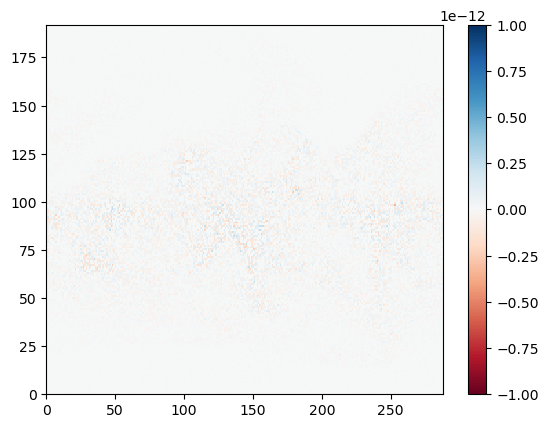

In [48]:
#coarse
dp_coarse = ((coarse_a_b['hyai'].rename({'hyai_dim':'level'}) * ds['P0']) + (coarse_a_b['hybi'].rename({'hybi_dim':'level'}) * ds['PS']))

#fine
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/archive/b.e.FTORCH_fullCNNfa_0004//atm/hist/b.e.FTORCH_fullCNNfa_0004.cam.h1.1850-01-17-00000.nc')
dp_fine = ((DS['hyai'] * DS['P0']) + (DS['hybi'] * DS['PS']))

for i in range(192):
    for j in range(288):
        
        T_subset = np.array(ds['Q'].isel(latitude=i, longitude=j).squeeze())
        subset_level = np.array(dp_coarse.isel(latitude=i, longitude=j).squeeze())
        int_subset = np.sum(T_subset*np.diff(subset_level))
        
        T_original = np.array(DS['Q'].isel(lat=i, lon=j).squeeze())        
        fine_level = np.array(dp_fine.isel(lat=i, lon=j).squeeze())
        int_original = np.sum(T_original*np.diff(fine_level))

        int_diff = np.abs(int_subset - int_original)
        
        if int_diff > 1e-7 or np.isnan(int_diff): 
            print('diff: {}, ix: {}, iy: {}'.format(int_diff, i, j))
        
print('... done ...')

#### without the loop #####:
PWint_c = (ds['Q'].squeeze()*dp_coarse.diff('level').squeeze()).sum('level')
oner = DS['Q'].squeeze()
twoer = (dp_fine.diff('ilev').rename({'ilev':'lev'})).squeeze()
PWint_f = np.sum(oner.values*twoer.values,axis=0)
diff_int = PWint_f  - PWint_c.values
plt.pcolor(diff_int,cmap='RdBu',vmin=-1e-12,vmax=1e-12)
plt.colorbar()
plt.show()

## Package in a dask chunked be boop

In [64]:
project_num = 'NAML0001' #what project key dfo you have? 

# ### ++++++ dask NCAR client: 
print('...setting up dask client...')
if 'client' in locals():
    client = locals()["client"]
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')
from distributed import Client
from dask_jobqueue import PBSCluster

cluster = PBSCluster(project=project_num,walltime='06:00:00',cores=1, memory='70GB',shared_temp_directory='/glade/derecho/scratch/wchapman/tmp',queue='casper')
cluster.scale(jobs=40)
client = Client(cluster)
#### ----- dask NCAR client: 
client

...setting up dask client...
...shutdown client...


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.113:38685,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [17]:
%%time
# Load the configuration from the YAML file
config_file = './config_gather_cesm.yml'

# Load the configuration from the YAML file
with open(config_file) as f:
    config = yaml.safe_load(f)


# Access the necessary paths and configurations
base_path = config['data']['output_dir']
zarr_save_path = config['data']['zarr_save_path']
file_prefix = config['data']['file_prefix']

# Ensure the Zarr save path directory exists
os.makedirs(zarr_save_path, exist_ok=True)

# Define chunking
chunks = {'time': 12, 'lev': 10, 'lat': 'auto', 'lon': 'auto'}

# Loop over each year from 1979 to 2012
for year in range(2013, 2016):
    # Find all files for the current year based on the file prefix
    file_pattern = os.path.join(base_path, file_prefix.split('*')[0]+'*'+str(year)+'*.nc')
    files = sorted(glob.glob(file_pattern))
    
    if files:  # Proceed only if files exist for the year
        print(f"Processing year: {year} with {len(files)} files.")
        
        # Open files for the year with specified chunking
        ds = xr.open_mfdataset(files, chunks=chunks, combine='by_coords', 
                               parallel=True)

        print('....opened....')

        for vvar in config['data']['variables']:
            ds[vvar] = ds[vvar].transpose('time', 'level', 'latitude', 'longitude')
                
        # Define the output Zarr file path for the current year
        zarr_output = os.path.join(zarr_save_path, f"f.e21.CREDIT_climate_{year}.zarr")
        
        # Save the dataset as a Zarr file for the current year
        ds.to_zarr(zarr_output, mode='w')
        
        print(f"Saved Zarr store for year {year} to {zarr_output}")

    else:
        print(f"No files found for year {year}.")


Processing year: 2013 with 365 files.
....opened....
Saved Zarr store for year 2013 to /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_2013.zarr
Processing year: 2014 with 365 files.
....opened....
Saved Zarr store for year 2014 to /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_2014.zarr
No files found for year 2015.
CPU times: user 3min 54s, sys: 20.3 s, total: 4min 14s
Wall time: 10min 7s


## Mean and STD

In [65]:
# Define file path and list of datasets
fp = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/'
file_paths = [f'{fp}f.e21.CREDIT_climate_{year}.zarr' for year in range(1979, 2011)]

# Initialize accumulators for means, variances, and counts
combined_mean_numerator = 0
combined_count = 0
variance_numerator = 0
chunks = {'time': 'auto', 'lev': 10, 'lat': 'auto', 'lon': 'auto'}
# Loop through each dataset, calculating means and counts
for path in file_paths[:]:
    print('doing:', path)
    try:
        ds = xr.open_dataset(path, engine='zarr', chunks=chunks).drop(['hybm','hyam','hyai','hybi'])
    except: 
        ds = xr.open_dataset(path, engine='zarr', chunks=chunks)
    # Calculate mean and count over the specified dimensions
    ds_mean = ds.mean(['latitude', 'longitude', 'time'])
    count = ds.time.size  # count only over the time dimension
    
    # Accumulate weighted means and counts
    combined_mean_numerator += ds_mean * count
    combined_count += count
    
    # Calculate variance component and accumulate it
    ds_std = ds.std(['latitude', 'longitude', 'time'])
    variance_numerator += ((count - 1) * ds_std ** 2) + count * (ds_mean - combined_mean_numerator / combined_count) ** 2

# Finalize the combined mean and standard deviation
combined_mean = combined_mean_numerator / combined_count
combined_variance = variance_numerator / (combined_count - 1)
combined_std = np.sqrt(combined_variance)
print('writing')
# Save the results to NetCDF files
combined_mean.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg_new.nc')
print('writing std')
combined_std.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_2010_32lev_1.0deg_new.nc')

doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1979.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1980.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1981.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1982.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1983.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1984.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1985.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1986.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1987.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1988.zarr
doing: /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1989.zarr
doing: /glade/campaign/cisl/aiml/wchapman/M

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 14.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [67]:
client.shutdown()

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


## Mean and STD

In [33]:
fp = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/'
olist = []
for year in range(1984, 1989):
    olist.append(f'{fp}f.e21.CREDIT_climate_{year}.zarr')
DS = xr.open_mfdataset(olist,engine='zarr')
DSm = DS.mean(['latitude','longitude','time'])
DSm.load()
DSm.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_1988_10lev_1.0deg.nc')
DSm
DSs = DS.std(['latitude','longitude','time'])
DSs.load()
DSs.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_1988_10lev_1.0deg.nc')
DSs

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 16.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset>
Dimensions:   (level: 10)
Coordinates:
  * level     (level) float64 31.23 90.18 156.6 239.0 ... 730.0 873.5 955.9
Data variables: (12/37)
    CLDHGH    float64 0.4525
    CLDLOW    float64 0.4905
    CLDMED    float64 0.3884
    CLDTOT    float64 0.7542
    FLDS      float64 304.5
    FLNS      float64 49.5
    ...        ...
    TAUY      float64 -0.003282
    TREFHT    float64 277.8
    U         (level) float64 4.705 8.656 13.13 13.06 ... 3.406 1.104 0.2485
    U10       float64 6.5
    V         (level) float64 -0.003149 0.02129 -0.04105 ... 0.06438 0.1166
    ZMMU      (level) float64 0.0 6.611e-11 4.07e-07 ... 0.002519 0.002335

In [36]:
DSs = DS.std(['latitude','longitude','time'])
DSs.load()
DSs.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_1988_10lev_1.0deg.nc')
DSs

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 16.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset>
Dimensions:   (level: 10)
Coordinates:
  * level     (level) float64 31.23 90.18 156.6 239.0 ... 730.0 873.5 955.9
Data variables: (12/37)
    CLDHGH    float64 0.4497
    CLDLOW    float64 0.4341
    CLDMED    float64 0.4372
    CLDTOT    float64 0.3718
    FLDS      float64 95.69
    FLNS      float64 33.42
    ...        ...
    TAUY      float64 0.1138
    TREFHT    float64 21.82
    U         (level) float64 23.37 14.47 16.88 17.48 ... 11.53 9.287 8.833 8.28
    U10       float64 3.749
    V         (level) float64 9.444 6.852 9.729 11.87 ... 8.29 6.471 6.401 6.569
    ZMMU      (level) float64 0.0 4.75e-07 4.948e-05 ... 0.005466 0.005002

## Gather Latent Heat Flux

In [15]:

def preprocess_open_var(ds):
    """
    Preprocess function to select only the specified variable from a dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset opened by open_mfdataset.

    Returns:
    xarray.Dataset: Dataset containing only the specified variable.
    """
    var = 'LHFLX'  # Define the variable of interest
    return ds[[var]] if var in ds else xr.Dataset()


var = 'LHFLX'
# Loop over the specified years
for ii in range(1979, 2015):
    # Get all file paths for the current year
    print(f'doing {ii}')
    FNS = sorted(glob.glob(f'/glade/derecho/scratch/wchapman/archive/f.e21.CREDIT_climate/atm/hist/*.h1.*{ii}-*.nc'))
    
    # Ensure there are files for this year
    if FNS:
        # Load all files for the current year, using preprocess to select the variable
        DS = xr.open_mfdataset(FNS, preprocess=preprocess_open_var, combine='by_coords', parallel=True)
        
        # Save the concatenated dataset to a NetCDF file
        DS.to_netcdf(f'outfile_LHFLX_{ii}.nc')  # Saves each year to a separate file for clarity
        print(f"Saved data for year {ii} to outfile_{ii}.nc")
    else:
        print(f"No files found for year {ii}")

doing 1979
Saved data for year 1979 to outfile_1979.nc
doing 1980
Saved data for year 1980 to outfile_1980.nc
doing 1981
Saved data for year 1981 to outfile_1981.nc
doing 1982
Saved data for year 1982 to outfile_1982.nc
doing 1983
Saved data for year 1983 to outfile_1983.nc
doing 1984
Saved data for year 1984 to outfile_1984.nc
doing 1985
Saved data for year 1985 to outfile_1985.nc
doing 1986
Saved data for year 1986 to outfile_1986.nc
doing 1987
Saved data for year 1987 to outfile_1987.nc
doing 1988
Saved data for year 1988 to outfile_1988.nc
doing 1989
Saved data for year 1989 to outfile_1989.nc
doing 1990
Saved data for year 1990 to outfile_1990.nc
doing 1991
Saved data for year 1991 to outfile_1991.nc
doing 1992
Saved data for year 1992 to outfile_1992.nc
doing 1993
Saved data for year 1993 to outfile_1993.nc
doing 1994
Saved data for year 1994 to outfile_1994.nc
doing 1995
Saved data for year 1995 to outfile_1995.nc
doing 1996
Saved data for year 1996 to outfile_1996.nc
doing 1997

In [36]:
for ii in range(1980, 2015):
    print(f'doing {ii}')
    zarr_store_path = f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{ii}.zarr'
    # Load the existing Zarr dataset
    existing_ds = xr.open_zarr(zarr_store_path)
    new_ds = xr.open_dataset(f'./outfile_LHFLX_{ii}.nc')
    new_ds = new_ds.rename({'lat':'latitude','lon':'longitude'}).chunk({'time':4,'latitude':'auto','longitude':'auto'})
    DS = xr.merge([existing_ds,new_ds])
    DS.to_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{ii}_v2.zarr')

doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
doing 2014


In [37]:
for ii in range(1979, 2015):
    zarr_store_path = f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{ii}.zarr'
    
    # Load the existing Zarr dataset
    existing_ds = xr.open_zarr(zarr_store_path, consolidated=True)
    
    # Open the new dataset with the LHFLX variable, rename dimensions, and set chunks
    new_ds = xr.open_dataset(f'./outfile_LHFLX_{ii}.nc')
    new_ds = new_ds.rename({'lat': 'latitude', 'lon': 'longitude'}).chunk({'time': 4, 'latitude': 'auto', 'longitude': 'auto'})
    
    # Extract only the LHFLX variable
    lhflx_data = new_ds[['LHFLX']]

    # Append LHFLX to the existing Zarr store, without specifying append_dim
    lhflx_data.to_zarr(zarr_store_path, mode='a')
    
    print(f"Appended LHFLX data for year {ii} to the existing Zarr store at {zarr_store_path}")


Appended LHFLX data for year 1979 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1979.zarr
Appended LHFLX data for year 1980 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1980.zarr
Appended LHFLX data for year 1981 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1981.zarr
Appended LHFLX data for year 1982 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1982.zarr
Appended LHFLX data for year 1983 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1983.zarr
Appended LHFLX data for year 1984 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_1984.zarr
Appended LHFLX data for year 1985 to the existing Zarr store at /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_19

In [40]:
DS = xr.open_mfdataset(sorted(glob.glob('./outfile_LHFLX_*.nc')),parallel=True)

In [52]:
BB = DS.mean()
print(np.array(BB.to_array()))
SS = DS.std()
print(np.array(SS.to_array()))

[62.75882674]
[77.09167291]


In [60]:
DSm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg.nc')
DSs = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg.nc')
DSm['LHFLX']=62.75882674
DSs['LHFLX']=77.09167291
DSm.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/mean_6h_1979_2010_32lev_1.0deg_v2.nc')
DSs.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/std_6h_1979_2010_32lev_1.0deg_v2.nc')

In [70]:
DStot = xr.combine_by_coords(DSset)
DStot

<xarray.Dataset>
Dimensions:    (latitude: 192, longitude: 288, time: 52560)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1979-01-01 00:00:00 ... 2014-12-31 18:00:00
Data variables:
    SOLIN      (time, latitude, longitude) float64 dask.array<chunksize=(4, 192, 288), meta=np.ndarray>

## Gather Forcings

In [76]:
DSset = [] 
for bb in range(1979,2015):
    DS = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{bb}_v2.zarr')
    DSset.append(DS['SOLIN'].to_dataset(name='SOLIN'))
DStot = xr.combine_by_coords(DSset)

#add Statics: 
DSstat = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg.nc')

DStot['PHIS'] = DSstat['PHIS']
DStot['z_norm'] = DSstat['z_norm']
DStot['LANDM_COSLAT'] = DSstat['LANDM_COSLAT']
DStot['LANDFRAC'] = DSstat['LANDFRAC']
DStot.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.statics_1.0deg.nc')

In [2]:
xr

NameError: name 'xr' is not defined

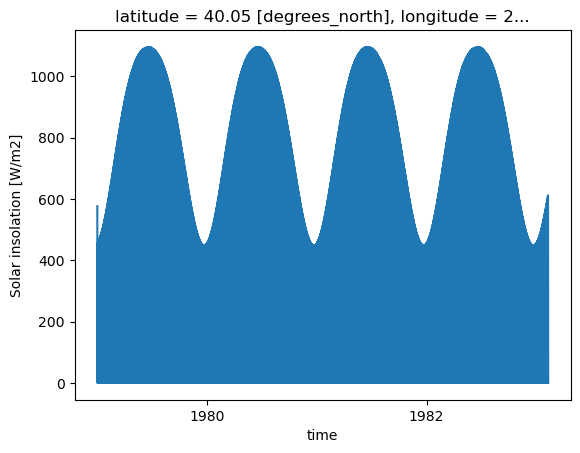

In [82]:
DSsun = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.statics_1.0deg.nc')
DSsun.sel(latitude=40,longitude=200,method='nearest')['SOLIN'].isel(time=slice(0,6000)).plot()

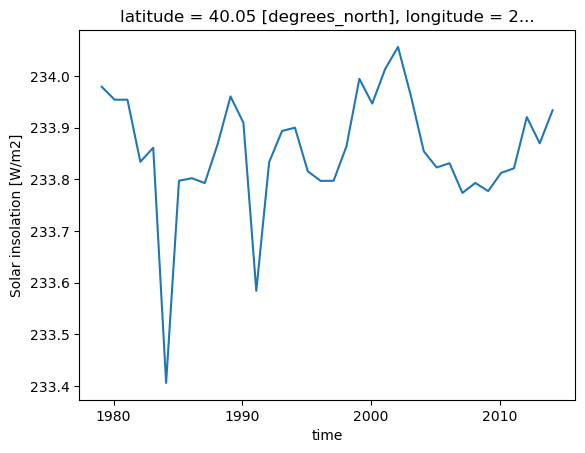

In [94]:
# Select the nearest location to latitude 40 and longitude 200
DSsun_loc = DSsun.sel(latitude=40, longitude=200, method='nearest')

# Select the time indices where the day of year is 30
DSsun_day30 = DSsun_loc.sel(time=DSsun_loc['time'].where(DSsun_loc['time'].dt.dayofyear == 30, drop=True))
DSsun_day30 = DSsun_day30.sel(time=DSsun_loc['time'].where(DSsun_day30['time'].dt.hour == 6, drop=True))
DSsun_day30['SOLIN'].plot()

## Developement Below:

In [53]:
month_expanded = ds['time.month'].broadcast_like(ds['PS'])
# Alternatively, you can expand the dimensions manually
# month_expanded = ds['time.month'].expand_dims({'lat': lat, 'lon': lon}, axis=(1, 2))
month_expanded = month_expanded-1
month_corrected = month_expanded.where(month_expanded != 0, 12) # check this line... 
# ds['month_expanded'] = month_corrected

In [55]:
month_expanded 
month_corrected = month_expanded.where(month_expanded != 0, 12) # check this line... 


In [57]:
ds['time.month']

<xarray.DataArray 'month' (time: 1)> Size: 8B
array([1])
Coordinates:
  * time     (time) object 8B 1850-01-17 00:00:00

In [5]:
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/test_gather/b.e.FTORCH_fullCNNfa_0004.cam.h1.1850-01-05-00000_processed.nc')
DSOG = xr.open_dataset('/glade/derecho/scratch/wchapman/archive/b.e.FTORCH_fullCNNfa_0004/atm/hist/b.e.FTORCH_fullCNNfa_0004.cam.h1.1850-01-05-00000.nc')

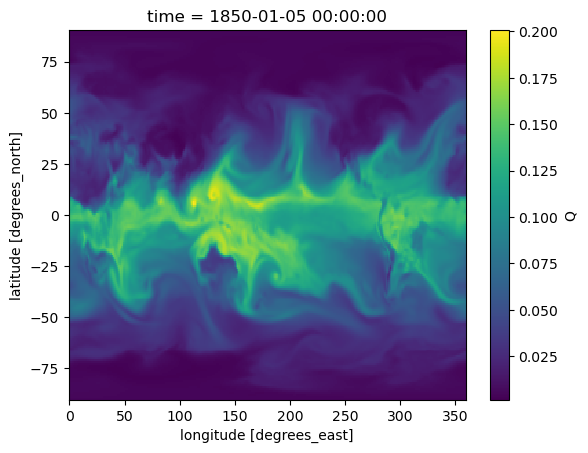

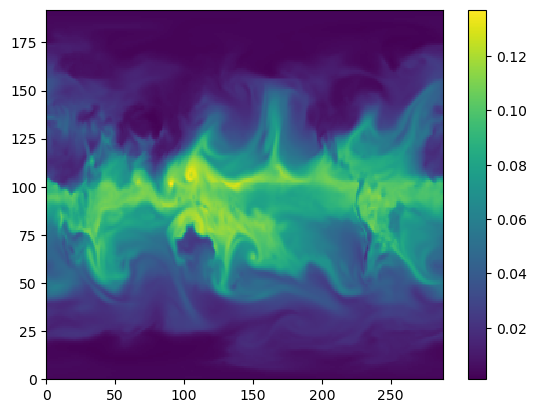

In [37]:
DSOG['Q'].squeeze().sum('lev').plot()
plt.show()

resid = DSOG['Q'].squeeze().sum('lev').values - DS['Q'].squeeze().sum('levels').values

plt.pcolor(resid)
plt.colorbar()
plt.show()

In [ ]:
# def vertical_integral(
#     integrand: torch.Tensor,
#     surface_pressure: torch.Tensor,
#     sigma_grid_offsets_ak: torch.Tensor,
#     sigma_grid_offsets_bk: torch.Tensor,
# ) -> torch.Tensor:
#     """Computes a vertical integral, namely:

#     (1 / g) * ∫ x dp

#     where
#     - g = acceleration due to gravity
#     - x = integrad
#     - p = pressure level

#     Args:
#         integrand (lat, lon, vertical_level), (kg/kg)
#         surface_pressure: (lat, lon), (Pa)
#         sigma_grid_offsets_ak: Sorted sigma grid offsets ak, (vertical_level + 1,)
#         sigma_grid_offsets_bk: Sorted sigma grid offsets bk, (vertical_level + 1,)

#     Returns:
#         Vertical integral of the integrand (lat, lon).
#     """
#     ak, bk = sigma_grid_offsets_ak, sigma_grid_offsets_bk
#     pressure_thickness = ((ak + (surface_pressure.unsqueeze(-1) * bk))).diff(
#         dim=-1
#     )  # Pa
#     integral = torch.sum(pressure_thickness * integrand, axis=-1)  # type: ignore
#     return 1 / GRAVITY * integral

# def compute_vertical_coarsening(
#     ds: xr.Dataset,
#     vertically_resolved_names: Sequence[str],
#     interface_indices: Sequence[Tuple[int, int]],
#     dim: str,
#     pressure_thickness_name: str,
# ) -> xr.Dataset:
#     """Compute vertical coarsening of 3D variables by mass-weighted mean. Outputs are
#     saved as new variables in the dataset with the name '{name}_{i}' where i is the
#     new coarse vertical level index."""
#     coarsened_arrays = {}
#     for i, (start, end) in enumerate(interface_indices):
#         pressure_thickness = ds[pressure_thickness_name].isel({dim: slice(start, end)})
#         for name in vertically_resolved_names:
#             array_slice = ds[name].isel({dim: slice(start, end)})
#             coarsened_da = weighted_mean(array_slice, pressure_thickness, dim)
#             current_long_name = array_slice.long_name
#             coarsened_da.attrs["long_name"] = current_long_name + f" level-{i}"
#             coarsened_arrays[f"{name}_{i}"] = coarsened_da
#     return ds.assign(coarsened_arrays)



In [4]:
ds

<xarray.Dataset> Size: 436MB
Dimensions:          (lat: 192, lon: 288, lev: 32, ilev: 33, time: 1, nbnd: 2,
                      coarse_mid_levs: 10)
Coordinates:
  * lat              (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon              (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lev              (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev             (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time             (time) object 8B 1850-01-11 00:00:00
  * coarse_mid_levs  (coarse_mid_levs) float64 80B 31.23 90.18 ... 873.5 955.9
Dimensions without coordinates: nbnd
Data variables: (12/76)
    gw               (lat) float64 2kB ...
    hyam             (lev) float64 256B ...
    hybm             (lev) float64 256B ...
    P0               float64 8B ...
    hyai             (ilev) float64 264B ...
    hybi             (ilev) float64 264B ...
    ...               ...
    cb24cnn_V        (time, lev, lat, lon) float64 14MB ...
    plev_thickness   (lev, time, lat, lon) float64 14MB 277.6 277.6 ... 1.48e+03
    U_coarse         (coarse_mid_levs, time, lat, lon) float64 4MB 0.1189 ......
    V_coarse         (coarse_mid_levs, time, lat, lon) float64 4MB 1.132 ... ...
    T_coarse         (coarse_mid_levs, time, lat, lon) float64 4MB 244.3 ... ...
    Q_coarse         (coarse_mid_levs, time, lat, lon) float64 4MB 2.141e-06 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e.FTORCH_fullCNNfa_0004
    logname:           wchapman
    host:              derecho6
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001_v3hist.cam.i.0...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

## weighted course graining

In [247]:
def weighted_average_with_pressure_and_ref(variable, reference_pressure, coarse_indices):
    # Initialize list for coarse averages and reference pressure averages
    coarse_avg = []
    coarse_pressure_avg = []
    
    # Loop over each coarse layer
    for i in range(len(coarse_indices) - 1):
        # Get fine levels for this coarse layer
        lower_bound = coarse_indices[i]
        upper_bound = coarse_indices[i + 1]
        
        # Subset the reference pressure and variable for this range
        pressure_fine = reference_pressure.isel(lev=slice(lower_bound, upper_bound))
        variable_fine = variable.isel(lev=slice(lower_bound, upper_bound))
        
        # Compute pressure thickness (difference between fine levels)
        dp_fine = pressure_fine.diff(dim='lev')
        
        # Weighted average of the variable over pressure thickness
        weighted_avg = (variable_fine.isel(lev=slice(1, None)) * dp_fine).sum(dim='lev') / dp_fine.sum(dim='lev')
        coarse_avg.append(weighted_avg)
        
        # Weighted average of reference pressure
        pressure_weighted_avg = (pressure_fine.isel(lev=slice(1, None)) * dp_fine).sum(dim='lev') / dp_fine.sum(dim='lev')
        coarse_pressure_avg.append(pressure_weighted_avg)
    
    # Concatenate the coarse averages along the new dimension 'lev_coarse'
    return xr.concat(coarse_avg, dim='lev_coarse'), xr.concat(coarse_pressure_avg, dim='lev_coarse')

coarse_indices = [0, 6, 12, 14, 17, 19, 20, 21, 25, 27, 31]

pressure_levels = ((DS['hyam']*DS['P0'])+(DS['hybm']*DS['PS']))
coarse_pressure_bounds = pressure_levels.isel(lev=coarse_indices)
reference_pressure = (DS['hyam'] + DS['hybm'])*100000
coarse_reference_pressure = reference_pressure.isel(lev=coarse_indices)

In [248]:
# Apply the function to temperature
coarse_U, coarse_reference_pressure_avg = weighted_average_with_pressure_and_ref(DS['U'], reference_pressure, coarse_indices)

# Set the lev_coarse dimension of coarse_T to the coarse_reference_pressure_avg
coarse_U = coarse_U.assign_coords(lev_coarse=coarse_reference_pressure_avg)

In [338]:
FNS = sorted(glob.glob(f'/atm/hist/*h1*'))
DS = xr.open_dataset(FNS[10])
weights = np.cos(np.deg2rad(DS['lat']))
GRAVITY = 9.81

#pressure level thickness: 
dph = ((DS['hyai']*DS['P0'])+(DS['hybi']*DS['PS'])).diff('ilev')
dph = np.abs(dph)
dph = dph.rename({'ilev':'lev'})
dph['lev']=DS['lev']
dph = dph.to_dataset(name='plev_thickness')
DS = xr.merge([DS,dph])
DS['plev_thickness'].attrs['long_name'] = 'Pressure Layer Thickness'
DS['plev_thickness'].attrs['units'] = 'Pa'
coarse_indices = conf['data']['coarse_levs']


def get_mid_ak_bk(
    ds: xr.Dataset,
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
)  -> xr.Dataset:

    """Compute vertical coarsening of 3D variables by mass-weighted mean. Outputs are
    saved as new variables in the dataset with the name '{name}_{i}' where i is the
    new coarse vertical level index."""
    coarsened_arrays = []
    for i, (start, end) in enumerate(interface_indices):
        name = 'lev'
        DP = (1000 * (DS['hyam']+DS['hybm'])).isel({dim: slice(start, end)})
        array_slice = ds[name].isel({dim: slice(start, end)})
        # print(array_slice)
        coarsened_da = weighted_mean(array_slice, DP, dim)

        coarsened_arrays.append(float(coarsened_da.values))
        ds['coarse_mid_levs'] = coarsened_arrays
    return ds
        
def get_coarse_ak_bk(
    str_to_ds,
    interface_indices: Sequence[Tuple[int, int]],
    z_dim="ilev",
    time_dim="time",
) -> xr.Dataset:
    """Return dataset with scalar ak and bk coordinates that define coarse interfaces.

    Args:
        url: path to netCDF file with ak and bk variables in format output by FV3GFS.
        interface_indices: list of tuples of indices of the interfaces in the vertical.
        z_dim: name of dimension along which ak and bk are defined.
        time_dim: name of time dimension.

    Returns:
        xr.Dataset with ak and bk variables as scalars labeled as ak_0, bk_0, etc.

    Note:
        The ak and bk variables will have one more vertical level than the other 3D
        variables since they represent the interfaces between levels.
    """

    vertical_coordinate = xr.open_dataset(str_to_ds).load()
    # squeeze out the singleton time dimension
    vertical_coordinate = vertical_coordinate.squeeze()
    data = {}
    for i, (start, end) in enumerate(interface_indices):
        data[f"hyai_{i}"] = vertical_coordinate["hyai"].isel({z_dim: start})
        data[f"hybi_{i}"] = vertical_coordinate["hybi"].isel({z_dim: start})
        if i == len(interface_indices) - 1:
            data[f"hyai_{i + 1}"] = vertical_coordinate["hyai"].isel({z_dim: end})
            data[f"hybi_{i + 1}"] = vertical_coordinate["hybi"].isel({z_dim: end})
    for i in range(len(interface_indices) + 1):
        data[f"hyai_{i}"].attrs["units"] = "Pa"
        data[f"hybi_{i}"].attrs["units"] = ""  # unitless quantity
        for name in ["hyai", "hybi"]:
            data[f"{name}_{i}"] = data[f"{name}_{i}"].drop_vars([z_dim, time_dim])
    return xr.Dataset(data)

def weighted_mean(da: xr.DataArray, weights: xr.DataArray, dims) -> xr.DataArray:
    """Compute weighted mean of xr.DataArray."""
    return (da * weights).sum(dims) / weights.sum(dims)


def compute_vertical_coarsening(
    ds: xr.Dataset,
    vertically_resolved_names: Sequence[str],
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
) -> xr.Dataset:
    """Compute vertical coarsening of 3D variables by mass-weighted mean. Outputs are
    saved as new variables in the dataset with the name '{name}_{i}' where i is the
    new coarse vertical level index."""
    coarsened_arrays = {}
    for i, (start, end) in enumerate(interface_indices):
        pressure_thickness = ds[pressure_thickness_name].isel({dim: slice(start, end)})
        for name in vertically_resolved_names:
            array_slice = ds[name].isel({dim: slice(start, end)})
            coarsened_da = weighted_mean(array_slice, pressure_thickness, dim)
            current_long_name = array_slice.long_name
            coarsened_da.attrs["long_name"] = current_long_name + f" level-{i}"
            coarsened_arrays[f"{name}_{i}"] = coarsened_da
    return ds.assign(coarsened_arrays)

def compute_vertical_coarsening_2(
    ds: xr.Dataset,
    vertically_resolved_names: Sequence[str],
    interface_indices: Sequence[Tuple[int, int]],
    dim: str,
    pressure_thickness_name: str,
    coarse_mid_levs: str = "coarse_mid_levs",
) -> xr.Dataset:
    """Compute vertical coarsening of 3D variables by mass-weighted mean. Each input variable is 
    coarsened and saved as a new variable with shape `[time, coarse_mid_levs, lat, lon]`.
    """
    coarsened_variables = {}

    for name in vertically_resolved_names:
        coarsened_slices = []
        
        for i, (start, end) in enumerate(interface_indices):
            # Extract the relevant slices for the variable and pressure thickness
            pressure_thickness = ds[pressure_thickness_name].isel({dim: slice(start, end)})
            array_slice = ds[name].isel({dim: slice(start, end)})
            
            # Compute the mass-weighted mean for this slice
            coarsened_da = weighted_mean(array_slice, pressure_thickness, dim)
            
            # Add the current `coarse_mid_levs` level as a new dimension coordinate
            coarsened_da = coarsened_da.expand_dims({coarse_mid_levs: [ds[coarse_mid_levs].values[i]]})
            
            # Collect coarsened slices
            coarsened_slices.append(coarsened_da)
        
        # Concatenate along the `coarse_mid_levs` dimension
        coarsened_variable = xr.concat(coarsened_slices, dim=coarse_mid_levs)
        
        # Store the coarsened variable in the dictionary
        coarsened_variables[f'{name}_coarse'] = coarsened_variable

    # Assign the coarsened variables back to the original dataset
    return ds.assign(coarsened_variables)



def compute_column_moisture_integral(
    ds: xr.Dataset,
    input_name: str,
    output_name: str,
    pressure_thickness_name: str,
    dim: str,
) -> xr.Dataset:
    """Compute the column integral of a mass mixing ratio."""
    column_integral = (ds[input_name] * ds[pressure_thickness_name]).sum(dim) / GRAVITY
    column_integral.attrs["units"] = "kg/m^2"
    column_integral.attrs["long_name"] = output_name.replace("_", " ")
    return ds.assign({output_name: column_integral})

# def vertical_integral(
#     integrand: torch.Tensor,
#     surface_pressure: torch.Tensor,
#     sigma_grid_offsets_ak: torch.Tensor,
#     sigma_grid_offsets_bk: torch.Tensor,
# ) -> torch.Tensor:
#     """Computes a vertical integral, namely:

#     (1 / g) * ∫ x dp

#     where
#     - g = acceleration due to gravity
#     - x = integrad
#     - p = pressure level

#     Args:
#         integrand (lat, lon, vertical_level), (kg/kg)
#         surface_pressure: (lat, lon), (Pa)
#         sigma_grid_offsets_ak: Sorted sigma grid offsets ak, (vertical_level + 1,)
#         sigma_grid_offsets_bk: Sorted sigma grid offsets bk, (vertical_level + 1,)

#     Returns:
#         Vertical integral of the integrand (lat, lon).
#     """
#     ak, bk = sigma_grid_offsets_ak, sigma_grid_offsets_bk
#     pressure_thickness = ((ak + (surface_pressure.unsqueeze(-1) * bk))).diff(
#         dim=-1
#     )  # Pa
#     integral = torch.sum(pressure_thickness * integrand, axis=-1)  # type: ignore
#     return 1 / GRAVITY * integral

In [339]:
get_mid_ak_bk(DS,coarse_indices,'lev','plev_thickness')
coarse_a_b = get_coarse_ak_bk(FNS[10],coarse_indices)
ds = compute_vertical_coarsening_2(DS,['U','V','T','Q'],coarse_indices,'lev','plev_thickness')

In [341]:
ds['U_coarse']

<xarray.DataArray 'U_coarse' (coarse_mid_levs: 10, time: 1, lat: 192, lon: 288)> Size: 4MB
array([[[[ 1.18862036e-01,  9.41337877e-02,  6.93607339e-02, ...,
           1.92660397e-01,  1.68137067e-01,  1.43533710e-01],
         [ 1.02647174e-01,  8.38631829e-02,  6.49715640e-02, ...,
           1.58437062e-01,  1.39926547e-01,  1.21332462e-01],
         [ 1.56549668e-02, -3.46554307e-03, -2.26963111e-02, ...,
           7.23271691e-02,  5.35540022e-02,  3.46627700e-02],
         ...,
         [-9.49378813e+00, -1.01243747e+01, -1.07484491e+01, ...,
          -7.56519179e+00, -8.21398951e+00, -8.85692325e+00],
         [-1.30553769e+01, -1.37292322e+01, -1.43957081e+01, ...,
          -1.09923430e+01, -1.16866505e+01, -1.23744239e+01],
         [-1.66045660e+01, -1.73225858e+01, -1.80323609e+01, ...,
          -1.44044753e+01, -1.51451635e+01, -1.58786434e+01]]],


       [[[ 2.13597252e+00,  2.07728833e+00,  2.01761546e+00, ...,
           2.30581613e+00,  2.25026362e+00,  2.19364010e+00],
         [ 2.04347453e+00,  1.98633073e+00,  1.92859410e+00, ...,
           2.21122195e+00,  2.15593844e+00,  2.10001620e+00],
         [ 2.00563596e+00,  1.94116745e+00,  1.87651649e+00, ...,
...
           1.91837748e+00,  1.98051946e+00,  2.04003938e+00],
         [-1.18015517e+00, -1.03036678e+00, -8.80578599e-01, ...,
          -1.62952401e+00, -1.47973648e+00, -1.32994388e+00],
         [-4.43869629e+00, -4.24679207e+00, -4.05286679e+00, ...,
          -5.00137425e+00, -4.81607721e+00, -4.62848812e+00]]],


       [[[-2.46837610e+00, -2.42995211e+00, -2.39037091e+00, ...,
          -2.57652471e+00, -2.54167985e+00, -2.50562459e+00],
         [-3.78369094e+00, -3.68548928e+00, -3.58422209e+00, ...,
          -4.05764278e+00, -3.96995739e+00, -3.87857822e+00],
         [-3.82555416e+00, -3.66350056e+00, -3.49917618e+00, ...,
          -4.28785372e+00, -4.13843746e+00, -3.98379422e+00],
         ...,
         [ 1.40810718e+00,  1.40610572e+00,  1.40195613e+00, ...,
           1.39827731e+00,  1.40440154e+00,  1.40758638e+00],
         [-1.06849191e+00, -9.73803946e-01, -8.79339224e-01, ...,
          -1.35457178e+00, -1.25881436e+00, -1.16347460e+00],
         [-3.79181552e+00, -3.65044672e+00, -3.50733840e+00, ...,
          -4.20480892e+00, -4.06906353e+00, -3.93137687e+00]]]])
Coordinates:
  * lat              (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon              (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time             (time) object 8B 1850-01-11 00:00:00
  * coarse_mid_levs  (coarse_mid_levs) float64 80B 31.23 90.18 ... 873.5 955.9

## Run

In [310]:
coarse_a_b = get_coarse_ak_bk(FNS[10],coarse_indices)
ds = compute_vertical_coarsening(DS,['U','V','T','Q'],coarse_indices,'lev','plev_thickness')

In [312]:
coarse_a_b 

<xarray.Dataset> Size: 176B
Dimensions:  ()
Data variables: (12/22)
    hyai_0   float64 8B 0.002255
    hybi_0   float64 8B 0.0
    hyai_1   float64 8B 0.04711
    hybi_1   float64 8B 0.0
    hyai_2   float64 8B 0.1314
    hybi_2   float64 8B 0.0
    ...       ...
    hyai_8   float64 8B 0.03164
    hybi_8   float64 8B 0.8137
    hyai_9   float64 8B 0.0192
    hybi_9   float64 8B 0.8811
    hyai_10  float64 8B 0.0
    hybi_10  float64 8B 1.0

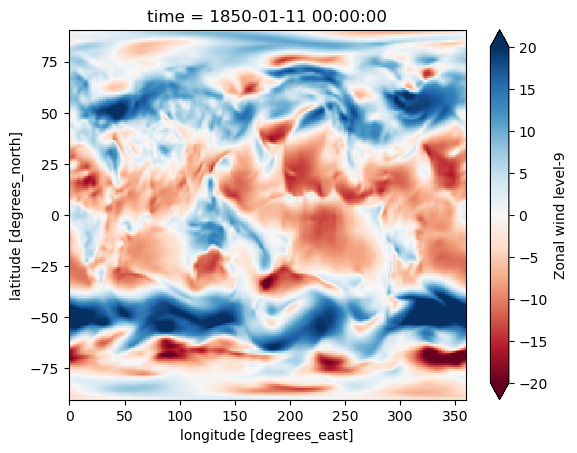

In [222]:
ds['U_9'].plot(vmin=-20,vmax=20,cmap='RdBu')


In [257]:
coarse_a_b

<xarray.Dataset> Size: 176B
Dimensions:  ()
Data variables: (12/22)
    hyai_0   float64 8B 0.002255
    hybi_0   float64 8B 0.0
    hyai_1   float64 8B 0.04711
    hybi_1   float64 8B 0.0
    hyai_2   float64 8B 0.1314
    hybi_2   float64 8B 0.0
    ...       ...
    hyai_8   float64 8B 0.03164
    hybi_8   float64 8B 0.8137
    hyai_9   float64 8B 0.0192
    hybi_9   float64 8B 0.8811
    hyai_10  float64 8B 0.0
    hybi_10  float64 8B 1.0

## Dpressure Level thickness